<a href="https://colab.research.google.com/github/BecomeAllan/ML-SLRC/blob/main/Application/Classification_automation_SLR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install S2query
!pip install transformers==4.16.2
!pip install torchmetrics==0.8.0

# !pip install matplotlib==3.5.1

ERROR: Operation cancelled by user


# Search no Semantic scholar

In [1]:
from itertools import chain
import numpy as np


## Utilizando a API para fazer a busca de dados

In [2]:
from S2query import S2paperAPI

import pandas as pd
import ipywidgets as widgets
from IPython.display import HTML, display, clear_output
import unicodedata
import re
import time


class SearcherAPI():
  def __init__(self):
    # cria o objeto para puxar os dados
    self.obj = S2paperAPI()

    # Cria os buttoes/textbox
    self.search_b = widgets.Button(description="Search")
    self.search_text =  widgets.Textarea(
    value="'artificial intelligence'+'Deep Learning'",
    placeholder='Type something',
    # description=':',
    disabled=False
)
    # Configura a localizacao dos botoes/textbox
    self.hbox = widgets.HBox([self.search_b, self.search_text])    
    
    # Funcao quando clicar o botao
    self.search_b.on_click(self.search_button)


  # Search button
  def search_button(self, p):
    print(self.search_text.value)
    # Busca os dados
    self.obj.get(self.search_text.value, n=100, sort = "total-citations", fieldsOfStudy = ['biology'])

    # Guarda os dados achados
    self.data = self.obj.all
  
  # Funcao para chamar a classe
  def __call__(self):
    clear_output()
    # Mostra os butoes
    display(self.hbox)

    

result = SearcherAPI()
result()

In [4]:
result.data.head()

AttributeError: ignored

## Utilizando a Web para fazer a busca de dados

In [3]:
from S2query import S2paperWeb

import pandas as pd
import ipywidgets as widgets
from IPython.display import HTML, display, clear_output
import unicodedata
import re
import time


class SearcherWeb():
  def __init__(self):
    # cria o objeto para puxar os dados
    self.obj = S2paperWeb()

    # Cria os buttoes/textbox
    self.search_b = widgets.Button(description="Search")
    self.search_text =  widgets.Textarea(
    value="'artificial intelligence'+'Deep Learning'",
    placeholder='Type something',
    # description=':',
    disabled=False
)
    # Configura a localizacao dos botoes/textbox
    self.hbox = widgets.HBox([self.search_b, self.search_text])

    # Funcao quando clicar o botao
    self.search_b.on_click(self.search_button)


  # Search button
  def search_button(self, p):
    print(self.search_text.value)
    # Busca os dados
    self.obj.get(self.search_text.value, n=100,
                 sort = "relevance", fieldsOfStudy = [],
                 publicationTypes = ['JournalArticle'])

    # Guarda os dados achados
    self.data = self.prepare_data(self.obj.all)
  
  # cria um subset dictionary da funcao que busca os dados
  def subset(self, dicttosub):
    # Seleciona apenas ('title','paperAbstract','year', 'links')
    subdict = {k:dicttosub[k] for k in ('title','paperAbstract','year', 'links')}

    # Renomeia a key do dictionar
    subdict['abstract'] = subdict.pop('paperAbstract')
    
    # Guarda apenas um link de referencia
    try:
      subdict['links'] = subdict['links'][0]['url']
    except:
      subdict['links'] = np.nan
    return subdict

  # Trata os dados para transformar de json para pandas.dataframe
  def prepare_data(self, data):

    # Loop sobre os resultados para selecionar tudo em uma lista
    papers = []
    for x in data['Results']:
      papers_page = [self.subset(paper) for paper in x['Page']['Papers']]
      papers.append(papers_page)
    papers = list(chain.from_iterable(papers))

    # Transforma em Pandas
    data = pd.DataFrame(papers)
    return data
  
  # Funcao para chamar a classe
  def __call__(self):
    clear_output()
    # Mostra os butoes
    display(self.hbox)


result = SearcherWeb()
result.hbox
result()

'artificial intelligence'+'Deep Learning'


Searching...


[_runtime]>> Start searching...

 ---
Total Results: 45405
Total Pages: 4540
Query Suggestions: []
--- 

[_extract] >> extracting relevant data.
[_extract]>> Took 1.56s
[_runtime]>> Took 6.02s
[get]>> Took 6.11s


In [ ]:
result.data.head(10)

# Classificação dos dados não rotulados

primeira classificação dos dados para poder treinar o modelo

In [ ]:
%gui asyncio

import asyncio


In [209]:
from numpy.random.mtrand import randint
import pandas as pd
import ipywidgets as widgets
from ipywidgets import GridspecLayout
from IPython.display import HTML, display, clear_output, Markdown
import unicodedata
import re
import time
from scipy.stats import poisson



class Judger():
  def __init__(self, data, configure_text= True):
    self.data = data
    self.selected_indx = []
    self.index = 0
    self.included_count = 0
    self.excluded_count = 0
    
    
    density = poisson.pmf(range(len(self.data)), mu=10)

    self.shuffle = np.random.choice(
                     range(len(data)),
                     p=density,
                     replace=False,
                     size=len(data))


    self.next_b = widgets.Button(description="Next")
    self.previous_b = widgets.Button(description="Previous")

    # Configura a localizacao dos botoes


    # Funcao quando clicar nos botoes
    self.next_b.on_click(self.next_button)
    self.previous_b.on_click(self.prev_button)



    if configure_text:
      # cria uma coluca no data como text (title + abstract) para ser classificado pelo oraculo
      self.data.fillna(value='', inplace=True)
      self.data['text'] = self.data['title']  +'. ' + self.data['abstract']
      self.data['label'] = np.nan

    # Cria os buttoes
    self.Included = widgets.Button(description="Included")
    self.NIncluded = widgets.Button(description="Not Included")
    self.skip_b = widgets.Button(description="Skip")
    self.undo_b = widgets.Button(description="Undo")

    # Configura a localizacao dos botoes
    # self.Judger_grid = widgets.HBox([self.NIncluded, self.Included, self.skip_b, self.undo_b])
    
    # Funcao quando clicar o botao
    self.Included.on_click(self.Included_button)
    self.NIncluded.on_click(self.Not_Included_button)
    self.skip_b.on_click(self.skip_button)
    self.undo_b.on_click(self.undo_button)


    self.Judger_hbox1 = widgets.HBox([self.NIncluded, self.Included, self.skip_b])
    self.Judger_hbox2 = widgets.HBox([self.previous_b, self.next_b, self.undo_b])

    self.Judger_grid = widgets.VBox([self.Judger_hbox1,self.Judger_hbox2]) 


  # Incluir na revisao button
  def Included_button(self, p):
    self.data.loc[self.shuffle[self.index], 'label'] = 'positive'
    self.index += 1
    self.included_count += 1
    self.__call__()

  # Excluir da revisao button
  def Not_Included_button(self, p):
    self.data.loc[self.shuffle[self.index], 'label'] = 'negative'
    self.index += 1
    self.excluded_count += 1
    self.__call__()

  # Pular da revisao button
  def skip_button(self, p):
    try:
      self.index +=1
      text = self.data.loc[self.shuffle[self.index], 'text']
    except:
      self.index =0

    self.__call__()

  # Desfazer ultima revisao button
  def undo_button(self, p):
        # Testa se é possivel ir pro texto anterior
    text = self.data.loc[self.shuffle[self.index], 'text']
    if self.data.loc[self.shuffle[self.index], 'label'] == 'positive':
      self.included_count -= 1
    elif self.data.loc[self.shuffle[self.index], 'label'] == 'negative':
      self.excluded_count -= 1
    self.data.loc[self.shuffle[self.index], 'label'] = np.nan
      # self.index+=1


    self.__call__()


    

  # Next button
  def next_button(self, p):
    # Testa se é possivel ir pro proximo texto
    try:
      self.index +=1
      text = self.data.loc[self.shuffle[self.index], 'text']
    except:
      self.index =0
    self.__call__()

  # Prev button
  def prev_button(self, p):
    # Testa se é possivel ir pro texto anterior
    if self.index-1 <0:
      self.index = len(self.data) - 1
    else:
      self.index -= 1
    
    self.__call__()

  
  def __call__(self):
    clear_output()
    print(self.index)
    # Quais dados sao nao  rotulados
    criteria_na = self.data['label'].isna()

    # Se acabar de rotular todos os dados
    if sum(criteria_na) == 0 or self.index > len(self.data):
      return print('Finished')

    # Index aleatorio para selecionar um texto para classificacao
    indexs_unlabeled = self.data.loc[criteria_na].index

    # Guarda qual index foi separado pra classificar
    self.selected_indx.append(self.index)

    # Texto e Label do index
    text = self.data.loc[self.shuffle[self.index], 'text']
    label = self.data.loc[self.shuffle[self.index], 'label']
    
    # Print de alguns resultados
    print(f"Current example: {self.index+1} / {len(self.data)}")
    #print(self.shuffle)
    # if len(self.selected_indx) > 1 and not pd.isna(self.data.loc[self.selected_indx[-2], 'label']):
    #     print(f"Previous label: {self.data.loc[self.selected_indx[-2], 'label']}")

    print(f"Unlabeled: {sum(criteria_na)}")
    print(f"Not included examples: {self.excluded_count} | Included examples: {self.included_count}")
    display(self.Judger_grid)
    print('Text:')
    display(Markdown(text))
    print('Label:', label)
    # print(label)


In [ ]:
data = result.data.reset_index().rename(columns = {'index':'index_key'})
Judged = Judger(data)

Judged()

In [ ]:
data = Judged.data
# data = data.sort_values('label',0,1)
# data.head()

# Treinando o modelo para rotular os dados nao rotulados

In [ ]:
!git lfs install
!git clone https://huggingface.co/becomeallan/ML-SLRC

In [6]:
import sys
sys.path.append('/content/ML-SLRC/')

In [7]:
%matplotlib inline
import torch.nn.functional as F
import torch.nn as nn
import math
import torch
import numpy as np
import pandas as pd
import time
import transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.manifold import TSNE
from copy import deepcopy, copy
import seaborn as sns
import matplotlib.pylab as plt
from pprint import pprint
import shutil
import datetime
import re
import json
from pathlib import Path

SEED = 2222

gen_seed = torch.Generator().manual_seed(SEED)

##  Baixa o modelo pre-treinado ML-SLRC

In [8]:
path = '/content/ML-SLRC/'

model_path = path + 'model.pt'
info_path = path + 'Info.json'

In [9]:
from Util_funs import SLR_Classifier, Encoder, SLR_DataSet

# Baixa o modelo
model = torch.load(model_path)

In [10]:
from Util_funs import train_loop, prepare_data

# Baixa as meta informações do modelo treinado
with open(info_path, 'r') as f:
  Info = json.load(f)


# Configura algumas meta informações
Info["tokenizer"] = AutoTokenizer.from_pretrained(Info['model'],
                                          do_lower_case = True)
Info['tresh'] = 0.9
Info["inner_update_step_eval"] = 3
Info["inner_print"] = 1

## Treina o modelo

In [66]:
import tqdm
import pandas as pd
import ipywidgets as widgets
from IPython.display import HTML, display, clear_output, Markdown
import unicodedata
import re
import time

# Tipo de device para colocar o modelo  (GPU, CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class Train():
  def __init__(self, model, data, device, Info):
    self.data = data
    self.model = model
    self.Info= Info
    self.device = device
    self.trained = False

    self.index = 0

    # Cria o butao
    self.train_b = widgets.Button(description="Train")
    
    # Configura a localizacao dos botoes
    self.Train_hbox = widgets.HBox([self.train_b])
    
    # Funcao quando clicar o botao
    self.train_b.on_click(self.train_button)



  # Train button
  def train_button(self, p):
    clear_output()
    print('Training...')
    # Pre-processa os textos dos dados para passar no modelo
    self.data_train_loader, self.data_test_loader, self.data_train, self.data_test = prepare_data(self.data,
              train_size_per_class = 2,
              batch_size = {'train': self.Info['inner_batch_size'],
                            'test': 2},
              max_seq_length = self.Info['max_seq_length'],
              tokenizer = self.Info['tokenizer'],
              input = "text",
              output = "label")


    
    # Treina o modelo e pega o vetor da camada classifier
    self.logits, _, _, _ = train_loop(self.data_train_loader, self.data_test_loader,
                                                        self.model, self.device,
                                                        epoch = self.Info['inner_update_step'],
                                                        lr=self.Info['inner_update_lr'],
                                                        print_info=True,
                                                        name = 'test')


    # Sigmoid para deixar entre 0 e 1 a confiança das predições
    predictions = torch.sigmoid(self.logits) 

    # Guarda as predições nos dados de teste
    self.data_test['prediction'] = predictions
    # pd.concat(self.data_test['prediction'])

    
    self.data = self.data_test
    

    self.trained = True
    self.__call__()
    print('Done')

  
  def __call__(self):
    

    display(self.Train_hbox)



t = Train(model,data, device, Info)

t()

In [56]:
t.data.head(3)

,index_key,title,year,links,abstract,text,label,prediction
0,0,Artificial intelligence: Deep learning in onco...,2021,https://www.ncbi.nlm.nih.gov/pubmed/33765601,,Artificial intelligence: Deep learning in onco...,NaN,0.517536
1,1,Unseen Artificial Intelligence—Deep Learning P...,2021,https://pdfs.semanticscholar.org/a773/bea81b77...,Background: The early detection of carotid wal...,Unseen Artificial Intelligence—Deep Learning P...,NaN,0.456698
2,2,"Presenting artificial intelligence, deep learn...",2021,https://doi.org/10.1080/17453674.2021.1918389,Background and purpose — Artificial intelligen...,"Presenting artificial intelligence, deep learn...",NaN,0.742793


# Utilizando o modelo treinado para rankear as predições

In [60]:
# Classe que passa pelos textos para avaliar o criterio de rankeamento e classificacao do modelo
class Ranker(Judger):
  def __init__(self, data_test, treshold):
    Judger.__init__(self, data)
    self.treshold = treshold
    self.data = data_test.reset_index().drop("index", axis=1)

    self.index = 0

    # Cria os butoes
    self.next_b = widgets.Button(description="Next")
    self.previous_b = widgets.Button(description="Previous")

    # Configura a localizacao dos botoes
    self.hbox = widgets.HBox([self.previous_b, self.next_b])    

    # Funcao quando clicar nos botoes
    self.next_b.on_click(self.next_button)
    self.previous_b.on_click(self.prev_button)


  # Next button
  def next_button(self, p):
    # Testa se é possivel ir pro proximo texto
    try:
      self.index +=1
      text = self.data.loc[self.index, 'text']
    except:
      self.index =0

    self.__call__()

  # Prev button
  def prev_button(self, p):
    # Testa se é possivel ir pro texto anterior
    try:
      self.index -=1
      text = self.data.loc[self.index, 'text']
    except:
      self.index = len(self.data) - 1

    
    self.__call__()


  def __call__(self):
    clear_output()

    # Mostra os butoes
    display(self.hbox)

    # Pega o texto e a predicao do indice para avaliacao
    text = self.data.loc[self.index, 'text']
    prediction = self.data.loc[self.index, 'prediction']
    label = self.data.loc[self.index, 'label']

    # Mostra alguns resultados
    print('Label:', label)
    print('Prediction:', prediction)
    print('Included:', self.treshold <= prediction)
    print('Text:')
    display(Markdown(text))



In [ ]:
ranked_test_data = t.data_test.sort_values('prediction', ascending=False)

r = Ranker(ranked_test_data, treshold=0.5)
r()

In [ ]:
t.data_test['prediction'].hist()

4
Current example: 5 / 100
Unlabeled: 96
Not included examples: 2 | Included examples: 2


Text:


An artificial intelligence deep learning model for identification of small bowel obstruction on plain abdominal radiographs. Objectives: Small bowel obstruction is a common surgical emergency which can lead to bowel necrosis, perforation and death. Plain abdominal X-rays are frequently used as a first-line test but the availability of immediate expert radiological review is variable. The aim was to investigate the feasibility of using a deep learning model for automated identification of small bowel obstruction. Methods: A total of 990 plain abdominal radiographs were collected, 445 with normal findings and 445 demonstrating small bowel obstruction. The images were labelled using the radiology reports, subsequent CT scans, surgical operation notes and enhanced radiological review. The data were used to develop a predictive model comprising an ensemble of five convolutional neural networks trained using transfer learning. Results: The performance of the model was excellent with an area under the receiver operator curve (AUC) of 0.961, corresponding to sensitivity and specificity of 91 and 93% respectively. Conclusion: Deep learning can be used to identify small bowel obstruction on plain radiographs with a high degree of accuracy. A system such as this could be used to alert clinicians to the presence of urgent findings with the potential for expedited clinical review and improved patient outcomes. Advances in knowledge: This paper describes a novel labelling method using composite clinical follow-up and demonstrates that ensemble models can be used effectively in medical imaging tasks. It also provides evidence that deep learning methods can be used to identify small bowel obstruction with high accuracy.

Label: nan
Prediction: 0.24968731
(Model) Included: False


Button(description='Avaliation', style=ButtonStyle())

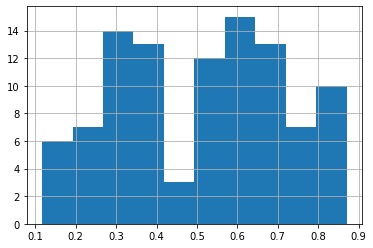

In [214]:
class Interface(Judger, Train):
  def __init__(self, data):
    self.treshold = 0.5
    Judger.__init__(self, data)
    Train.__init__(self, model, self.data, device, Info)

    self.avaliation_b = widgets.Button(description="Avaliation")
    # self.previous_b = widgets.Button(description="Previous")

    # Configura a localizacao dos botoes
    # self.Interface_hbox_text = widgets.HBox([self.previous_b, self.next_b])    

    # Funcao quando clicar nos botoes
    self.avaliation_b.on_click(self.avaliation_button)
    # self.previous_b.on_click(self.prev_button)


      # Next button
  def avaliation_button(self, p):
    # Testa se é possivel ir pro proximo texto
    self.data['prediction'].hist()

    self.__call__()


  def __call__(self):
    Judger.__call__(self)
    
    if (self.included_count >= 2 )& (self.excluded_count>= 2):
      if self.trained:
        text = self.data.loc[self.shuffle[self.index], 'text']
        prediction = self.data.loc[self.shuffle[self.index], 'prediction']

        # Mostra alguns resultados
        print('Prediction:', prediction)
        print('(Model) Included:', self.treshold <= prediction)

        display(self.avaliation_b)

      Train.__call__(self)


interface = Interface(result.data)
interface()

# Active Learning (Apenas um teste)

In [182]:
from scipy import stats
class active_learning(Judger):
  def __init__(self, data):
    self.data = data
    # print(self.data['label'])
    super(active_learning, self).__init__(data = self.data, configure_text=False)
    
    
 
  def __call__(self):
    clear_output()
    # Quais dados sao nao  rotulados
    criteria_na = self.data['label'].isna()

    # print(self.data)

    # Se acabar de rotular todos os dados
    if sum(criteria_na) == 0:
      return print('Finish')

    # Index aleatorio para selecionar um texto para classificacao
    unlabeled_data = self.data.loc[criteria_na]
    indexs_unlabeled = unlabeled_data.index
    
    prediction_unlabeled = unlabeled_data.loc[:, 'prediction']
    # prob = poisson.cdf(indexs_unlabeled, mu=1)
    
    kernel = stats.gaussian_kde(prediction_unlabeled)
    
    prob = kernel(prediction_unlabeled) / sum( kernel(prediction_unlabeled))


    self.index = np.random.choice(indexs_unlabeled, 1,
                                  replace=False,
                                  p = prob
                                  ).item()

    # Guarda qual index foi separado pra classificar
    self.selected_indx.append(self.index)

    # Texto e Label do index aleatorio
    text = self.data.loc[self.index, 'text']
    label = self.data.loc[self.index, 'label']
    prediction = self.data.loc[self.index, 'prediction']
    
    
    # Print de alguns resultados
    print('Unlabed:', sum(criteria_na))
    print(
          "Not included examples:", self.excluded_count,"|",
          "Included examples:", self.included_count)
    display(self.hbox)
    
    print('Prediction:', prediction)
    # print('Included:', self.treshold <= prediction)

    print('Previos Label:', label)
    print('Text:')
    display(Markdown(text))



In [ ]:
ranked_test_data['label'] = np.nan

ac = active_learning(data = ranked_test_data)

ac()